# Result Analysis for Deephyper Graph Neural Network
### Author: Shengli Jiang (sjiang87@wisc.edu)

### Datasets: QM7, QM8, QM9, ESOL, FreeSolv, Lipophilicity

In [1]:
import matplotlib
import lime
import pickle
import lime.lime_tabular
import sklearn.model_selection
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from treeinterpreter import treeinterpreter as ti
from analysis_utils import load_json, to_sec, three_random_split, three_random_mean_std,\
create_csv, plot_reward_vs_time, three_random_parity_plot, feature_importance, mol_vs_deep,\
moving_average

# sns.set()
# sns.set_context("talk", font_scale=1.5)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['legend.title_fontsize'] = 20
matplotlib.rcParams['legend.fontsize'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['figure.figsize'] = [8, 6]
matplotlib.rcParams["scatter.marker"] = 'o'
matplotlib.rcParams["lines.markersize"] = 5

## load data

In [2]:
QM7_PLOT_DIR = r"/mnt/d/plots/anl/fig/qm7_"
QM7_DATA_DIR = r"/mnt/d/machinelearning2/ANL/qm7/run_0721/"
QM7_data = load_json(QM7_DATA_DIR + 'data_2020-07-25_03.json')

QM8_PLOT_DIR = r"/mnt/d/plots/anl/fig/qm8_"
QM8_DATA_DIR = r"/mnt/d/machinelearning2/ANL/qm8/run_0721/"
QM8_data = load_json(QM8_DATA_DIR + 'data_2020-07-25_14.json')

QM9_PLOT_DIR = r"/mnt/d/plots/anl/fig/qm9_"
QM9_DATA_DIR = r'/mnt/d/machinelearning2/ANL/qm9/run_0728/'
QM9_data = load_json(QM9_DATA_DIR + 'data_2020-07-29_17.json')

ESOL_PLOT_DIR = r"/mnt/d/plots/anl/fig/ESOL_"
ESOL_DATA_DIR = r"/mnt/d/machinelearning2/ANL/ESOL/run_0721/"
ESOL_data = load_json(ESOL_DATA_DIR + 'data_2020-07-24_13.json')

FreeSolv_PLOT_DIR = r"/mnt/d/plots/anl/fig/FreeSolv_"
FreeSolv_DATA_DIR = r"/mnt/d/machinelearning2/ANL/FreeSolv/run_0721_extra/"
FreeSolv_data = load_json(FreeSolv_DATA_DIR + 'data_2020-07-24_13.json')

LIPO_PLOT_DIR = r"/mnt/d/plots/anl/fig/Lipo_"
LIPO_DATA_DIR = r"/mnt/d/machinelearning2/ANL/Lipo/run_0721/"
LIPO_data = load_json(LIPO_DATA_DIR + 'data_2020-07-21_14.json')

PLOT_DIR = r"/mnt/d/plots/anl/"

QM9_rs30 = load_json(r"/mnt/d/machinelearning2/ANL/qm9/run_rs30/data_2020-08-15_00.json")
QM9_rs15 = load_json(r"/mnt/d/machinelearning2/ANL/qm9/run_rs15/data_2020-08-22_02.json")
QM9_re60 = load_json(r"/mnt/d/machinelearning2/ANL/qm9/run_re60/data_2020-08-15_15.json")
QM9_re15 = load_json(r"/mnt/d/machinelearning2/ANL/qm9/run_re15/data_2020-08-22_02.json")

## Regularized evolution with 30 nodes

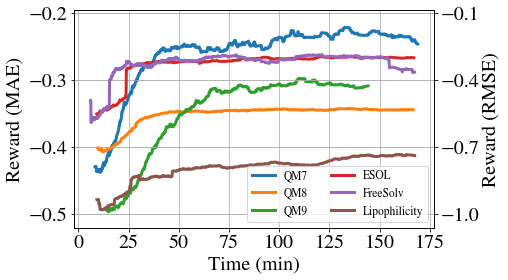

In [3]:
x, y = [], []

for data in [QM7_data, QM8_data, QM9_data, ESOL_data, FreeSolv_data, LIPO_data]:
    start_infos = data['start_infos'][0]
    try:
        start_time = to_sec(data['workload']['times'][0])
    except:
        start_time = to_sec(start_infos['timestamp'])
    times = [to_sec(ts)-start_time for ts in data['timestamps']]
    times, rewards = moving_average(times, data['raw_rewards'], window_size=100)
    x.append(times)
    y.append(rewards)

x = np.array(x) / 60
y = np.array(y)

fig, host = plt.subplots(figsize=(8, 4))
fig.subplots_adjust(right=0.75)
par1 = host.twinx()
cmap = plt.get_cmap("tab10")
p1, = host.plot(x[0], y[0], label='QM7', linewidth=3, color = 'tab:blue')
p2, = host.plot(x[1], y[1], label='QM8', linewidth=3, color = 'tab:orange')
p3, = host.plot(x[2], y[2], label='QM9', linewidth=3, color = 'tab:green')

p4, = par1.plot(x[3], -((-y[3])**0.5), label='ESOL', linewidth=3, color = 'tab:red')
p5, = par1.plot(x[4], -((-y[4])**0.5), label='FreeSolv', linewidth=3, color = 'tab:purple')
p6, = par1.plot(x[5], -((-y[5])**0.5), label='Lipophilicity', linewidth=3, color = 'tab:brown')
host.set_xlabel(r"Time (min)")
host.set_ylabel(r"Reward (MAE)")
par1.set_ylabel(r"Reward (RMSE)")
lines = [p1, p2, p3, p4, p5, p6]
par1.grid()
host.grid('both')
host.set_axisbelow(True)
par1.legend(lines,
            [l.get_label() for l in lines],
            fontsize=11.5,
            ncol=2,
            loc='lower right')
host.set_xticks([0, 25, 50, 75, 100, 125, 150, 175])
host.set_yticks([-0.5, -0.4, -0.3, -0.2])
par1.set_yticks([-1.0, -0.7, -0.4, -0.1])
host.set_ylim([-0.52, -0.195])
par1.set_ylim([-1.06, -0.085])
plt.savefig(PLOT_DIR+'total_reward.png', dpi=300, bbox_inches='tight')
plt.savefig(PLOT_DIR+'total_reward.svg', bbox_inches='tight')

## QM9 scaling analysis with 15, 30, 60 nodes

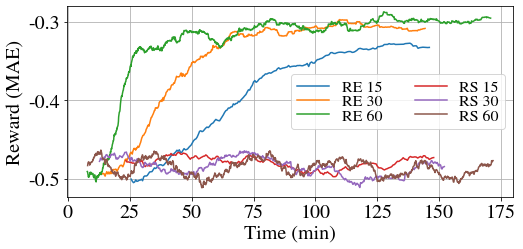

In [23]:
QM9_rs60 = load_json(r"/mnt/d/machinelearning2/ANL/qm9/run_rs60/data_2020-08-22_23.json")
QM9_rs30 = load_json(r"/mnt/d/machinelearning2/ANL/qm9/run_rs30/data_2020-08-15_00.json")
QM9_rs15 = load_json(r"/mnt/d/machinelearning2/ANL/qm9/run_rs15/data_2020-08-22_02.json")
QM9_re60 = load_json(r"/mnt/d/machinelearning2/ANL/qm9/run_re60/data_2020-08-15_15.json")
QM9_re15 = load_json(r"/mnt/d/machinelearning2/ANL/qm9/run_re15/data_2020-08-22_02.json")
QM9_re30 = load_json(QM9_DATA_DIR + 'data_2020-07-29_17.json')
x, y = [], []
for data in [QM9_re15, QM9_re30, QM9_re60, QM9_rs15, QM9_rs30, QM9_rs60]:
    start_infos = data['start_infos'][0]
    try:
        start_time = to_sec(data['workload']['times'][0])
    except:
        start_time = to_sec(start_infos['timestamp'])
    times = [to_sec(ts)-start_time for ts in data['timestamps']]
    times, rewards = moving_average(times, data['raw_rewards'], window_size=100)
    x.append(times)
    y.append(rewards)

x = np.array(x) / 60
y = np.array(y)
PLOT_DIR = r"/mnt/d/plots/anl/"
plt.figure(figsize=(8, 3.5))
plt.plot(x[0], y[0], label='RE 15')
plt.plot(x[1], y[1], label='RE 30')
plt.plot(x[2], y[2], label='RE 60')
plt.plot(x[3], y[3], label='RS 15')
plt.plot(x[4], y[4], label='RS 30')
plt.plot(x[5], y[5], label='RS 60')
plt.xlabel('Time (min)')
plt.ylabel('Reward (MAE)')
#plt.ylim([None, -0.28])
plt.legend(ncol=2,fontsize=16, loc='center right', labelspacing=0)
plt.xticks([0, 25, 50, 75, 100, 125, 150, 175], [0, 25, 50, 75, 100, 125, 150, 175])
plt.yticks([-0.3, -0.4, -0.5], [-0.3, -0.4, -0.5])
plt.ylim([None, -0.28])
plt.grid()
plt.savefig(PLOT_DIR+'qm9_search_compare.png', dpi=300, bbox_inches='tight')
plt.savefig(PLOT_DIR+'qm9_search_compare.svg', bbox_inches='tight')

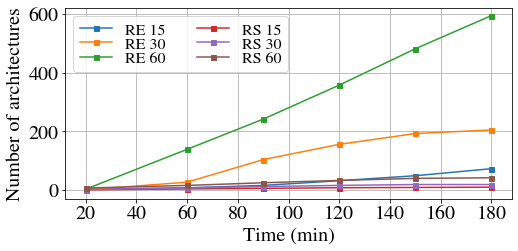

In [24]:
QM9_rs60 = load_json(r"/mnt/d/machinelearning2/ANL/qm9/run_rs60/data_2020-08-22_23.json")
QM9_rs30 = load_json(r"/mnt/d/machinelearning2/ANL/qm9/run_rs30/data_2020-08-15_00.json")
QM9_rs15 = load_json(r"/mnt/d/machinelearning2/ANL/qm9/run_rs15/data_2020-08-22_02.json")
QM9_re60 = load_json(r"/mnt/d/machinelearning2/ANL/qm9/run_re60/data_2020-08-15_15.json")
QM9_re15 = load_json(r"/mnt/d/machinelearning2/ANL/qm9/run_re15/data_2020-08-22_02.json")
QM9_re30 = load_json(QM9_DATA_DIR + 'data_2020-07-29_17.json')
x, y = [], []
for data in [QM9_re15, QM9_re30, QM9_re60, QM9_rs15, QM9_rs30, QM9_rs60]:
    start_infos = data['start_infos'][0]
    try:
        start_time = to_sec(data['workload']['times'][0])
    except:
        start_time = to_sec(start_infos['timestamp'])
    times = [to_sec(ts)-start_time for ts in data['timestamps']]
    times = np.array(times) / 60
    rewards = np.array(data['raw_rewards'])
    xt = np.array([20, 60, 90, 120, 150, 180])
    yt = []
    for t in xt:
        idx = np.intersect1d(np.where(times <= t)[0], np.where(rewards > -0.3)[0])
        archs = len(np.unique(np.array([space.denormalize(data['arch_seq'][i]) for i in idx]), axis=0))
        yt.append(archs)
    x.append(xt)
    y.append(yt)

x = np.array(x)
y = np.array(y)
PLOT_DIR = r"/mnt/d/plots/anl/"
plt.figure(figsize=(8, 3.5))
plt.plot(x[0], y[0], label='RE 15', marker='s')
plt.plot(x[1], y[1], label='RE 30', marker='s')
plt.plot(x[2], y[2], label='RE 60', marker='s')
plt.plot(x[3], y[3], label='RS 15', marker='s')
plt.plot(x[4], y[4], label='RS 30', marker='s')
plt.plot(x[5], y[5], label='RS 60', marker='s')
plt.xlabel('Time (min)')
plt.ylabel('Number of architectures')
#plt.ylim([None, -0.28])
plt.legend(ncol=2, fontsize=16, loc='upper left', labelspacing=0)
plt.xticks([20, 40, 60, 80, 100, 120, 140, 160, 180], [20, 40, 60, 80, 100, 120, 140, 160, 180])
plt.ylim([None, 620])
plt.grid()
plt.savefig(PLOT_DIR+'qm9_unique.png', dpi=300, bbox_inches='tight')
plt.savefig(PLOT_DIR+'qm9_unique.svg', bbox_inches='tight')

## QM8 scaling analysis with 15, 30, 60 nodes

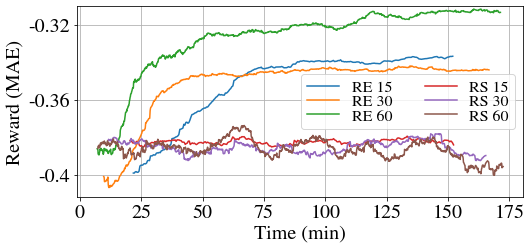

In [3]:
QM8_re15 = load_json(r"/mnt/d/machinelearning2/ANL/qm8/qm8_re15/data_2020-08-22_23.json")
QM8_re30 = load_json(r"/mnt/d/machinelearning2/ANL/qm8/run_0721/data_2020-07-25_14.json")
QM8_re60 = load_json(r"/mnt/d/machinelearning2/ANL/qm8/qm8_re60/data_2020-08-22_23.json")
QM8_rs15 = load_json(r"/mnt/d/machinelearning2/ANL/qm8/qm8_rs15/data_2020-08-22_23.json")
QM8_rs30 = load_json(r"/mnt/d/machinelearning2/ANL/qm8/qm8_rs30/data_2020-08-22_23.json")
QM8_rs60 = load_json(r"/mnt/d/machinelearning2/ANL/qm8/qm8_rs60/data_2020-08-23_02.json")

x, y = [], []
for data in [QM8_re15, QM8_re30, QM8_re60, QM8_rs15, QM8_rs30, QM8_rs60]:
    start_infos = data['start_infos'][0]
    try:
        start_time = to_sec(data['workload']['times'][0])
    except:
        start_time = to_sec(start_infos['timestamp'])
    times = [to_sec(ts)-start_time for ts in data['timestamps']]
    rewards = data['raw_rewards']
    times, rewards = moving_average(times, data['raw_rewards'], window_size=100)
    x.append(times)
    y.append(rewards)

x = np.array(x) / 60
y = np.array(y)
PLOT_DIR = r"/mnt/d/plots/anl/"
plt.figure(figsize=(8, 3.5))
plt.plot(x[0], y[0], label='RE 15')
plt.plot(x[1], y[1], label='RE 30')
plt.plot(x[2], y[2], label='RE 60')
plt.plot(x[3], y[3], label='RS 15')
plt.plot(x[4], y[4], label='RS 30')
plt.plot(x[5], y[5], label='RS 60')
plt.xlabel('Time (min)')
plt.ylabel('Reward (MAE)')
#plt.ylim([None, -0.28])
plt.legend(ncol=2,fontsize=16, loc='center right', labelspacing=0)
plt.xticks([0, 25, 50, 75, 100, 125, 150, 175], [0, 25, 50, 75, 100, 125, 150, 175])
plt.yticks([-0.4, -0.36, -0.32], [-0.4, -0.36, -0.32])
plt.ylim([None, -0.31])
plt.grid()
plt.savefig(PLOT_DIR+'qm8_search_compare.png', dpi=300, bbox_inches='tight')
plt.savefig(PLOT_DIR+'qm8_search_compare.svg', bbox_inches='tight')

189
346
796
68
132
240


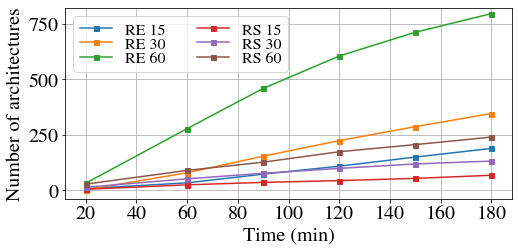

In [28]:
QM8_re15 = load_json(r"/mnt/d/machinelearning2/ANL/qm8/qm8_re15/data_2020-08-22_23.json")
QM8_re30 = load_json(r"/mnt/d/machinelearning2/ANL/qm8/run_0721/data_2020-07-25_14.json")
QM8_re60 = load_json(r"/mnt/d/machinelearning2/ANL/qm8/qm8_re60/data_2020-08-22_23.json")
QM8_rs15 = load_json(r"/mnt/d/machinelearning2/ANL/qm8/qm8_rs15/data_2020-08-22_23.json")
QM8_rs30 = load_json(r"/mnt/d/machinelearning2/ANL/qm8/qm8_rs30/data_2020-08-22_23.json")
QM8_rs60 = load_json(r"/mnt/d/machinelearning2/ANL/qm8/qm8_rs60/data_2020-08-23_02.json")
x, y = [], []
for data in [QM8_re15, QM8_re30, QM8_re60, QM8_rs15, QM8_rs30, QM8_rs60]:
    start_infos = data['start_infos'][0]
    try:
        start_time = to_sec(data['workload']['times'][0])
    except:
        start_time = to_sec(start_infos['timestamp'])
    times = [to_sec(ts)-start_time for ts in data['timestamps']]
    times = np.array(times) / 60
    rewards = np.array(data['raw_rewards'])
    xt = np.array([20, 60, 90, 120, 150, 180])
    yt = []
    for t in xt:
        idx = np.intersect1d(np.where(times <= t)[0], np.where(rewards > -0.35)[0])
        archs = len(np.unique(np.array([space.denormalize(data['arch_seq'][i]) for i in idx]), axis=0))
        yt.append(archs)
        if t  == 180:
            print(archs)
    x.append(xt)
    y.append(yt)

x = np.array(x)
y = np.array(y)
PLOT_DIR = r"/mnt/d/plots/anl/"
plt.figure(figsize=(8, 3.5))
plt.plot(x[0], y[0], label='RE 15', marker='s')
plt.plot(x[1], y[1], label='RE 30', marker='s')
plt.plot(x[2], y[2], label='RE 60', marker='s')
plt.plot(x[3], y[3], label='RS 15', marker='s')
plt.plot(x[4], y[4], label='RS 30', marker='s')
plt.plot(x[5], y[5], label='RS 60', marker='s')
plt.xlabel('Time (min)')
plt.ylabel('Number of architectures')
#plt.ylim([None, -0.28])
plt.legend(ncol=2,fontsize=16, loc='upper left', labelspacing=0)
plt.xticks([20, 40, 60, 80, 100, 120, 140, 160, 180], [20, 40, 60, 80, 100, 120, 140, 160, 180])
#plt.yticks([0, 50])
plt.ylim([None, 820])
plt.grid()
plt.savefig(PLOT_DIR+'qm8_unique.png', dpi=300, bbox_inches='tight')
plt.savefig(PLOT_DIR+'qm8_unique.svg', bbox_inches='tight')

## Lipo scaling analysis with 15, 30, 60 nodes

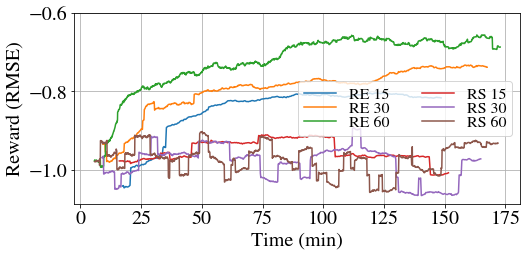

In [37]:
Lipo_re15 = load_json(r"/mnt/d/machinelearning2/ANL/Lipo/run_re15/data_2020-08-23_02.json")
Lipo_re30 = load_json(r"/mnt/d/machinelearning2/ANL/Lipo/run_0721/data_2020-07-21_14.json")
Lipo_re60 = load_json(r"/mnt/d/machinelearning2/ANL/Lipo/run_re60/data_2020-08-23_02.json")
Lipo_rs15 = load_json(r"/mnt/d/machinelearning2/ANL/Lipo/run_rs15/data_2020-08-23_14.json")
Lipo_rs30 = load_json(r"/mnt/d/machinelearning2/ANL/Lipo/run_rs30/data_2020-08-23_17.json")
Lipo_rs60 = load_json(r"/mnt/d/machinelearning2/ANL/Lipo/run_rs60/data_2020-08-23_14.json")
def moving_average(time_list, data_list, window_size=100):
    res_list = []
    times_list = []
    for i in range(len(data_list) - window_size):
        times_list.append(sum(time_list[i:i+window_size])/window_size)
        res_list.append(sum(data_list[i:i+window_size])/window_size)
    return np.array(times_list), np.array(res_list)
x, y = [], []
for data in [Lipo_re15, Lipo_re30, Lipo_re60, Lipo_rs15, Lipo_rs30, Lipo_rs60]:
    start_infos = data['start_infos'][0]
    try:
        start_time = to_sec(data['workload']['times'][0])
    except:
        start_time = to_sec(start_infos['timestamp'])
    times = [to_sec(ts)-start_time for ts in data['timestamps']]
    times, rewards = moving_average(times, data['raw_rewards'], window_size=100)
    x.append(times)
    y.append(rewards)

x = np.array(x) / 60
y = np.array(y)
PLOT_DIR = r"/mnt/d/plots/anl/"
plt.figure(figsize=(8, 3.5))
plt.plot(x[0], -(-y[0])**0.5, label='RE 15')
plt.plot(x[1], -(-y[1])**0.5, label='RE 30')
plt.plot(x[2], -(-y[2])**0.5, label='RE 60')
plt.plot(x[3], -(-y[3])**0.5, label='RS 15')
plt.plot(x[4], -(-y[4])**0.5, label='RS 30')
plt.plot(x[5], -(-y[5])**0.5, label='RS 60')
plt.xlabel('Time (min)')
plt.ylabel('Reward (RMSE)')
#plt.ylim([None, -0.28])
plt.legend(ncol=2,fontsize=16, loc='center right', labelspacing=0)
plt.xticks([0, 25, 50, 75, 100, 125, 150, 175], [0, 25, 50, 75, 100, 125, 150, 175])
plt.ylim([None, -0.6])
#plt.yticks([-0.4, -0.36, -0.32], [-0.4, -0.36, -0.32])
plt.grid()
plt.savefig(PLOT_DIR+'Lipo_search_compare.png', dpi=300, bbox_inches='tight')
plt.savefig(PLOT_DIR+'Lipo_search_compare.svg', bbox_inches='tight')

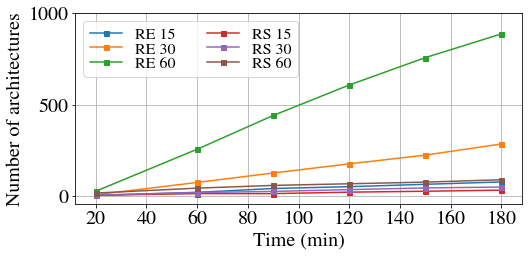

In [39]:
Lipo_re15 = load_json(r"/mnt/d/machinelearning2/ANL/Lipo/run_re15/data_2020-08-23_02.json")
Lipo_re30 = load_json(r"/mnt/d/machinelearning2/ANL/Lipo/run_0721/data_2020-07-21_14.json")
Lipo_re60 = load_json(r"/mnt/d/machinelearning2/ANL/Lipo/run_re60/data_2020-08-23_02.json")
Lipo_rs15 = load_json(r"/mnt/d/machinelearning2/ANL/Lipo/run_rs15/data_2020-08-23_14.json")
Lipo_rs30 = load_json(r"/mnt/d/machinelearning2/ANL/Lipo/run_rs30/data_2020-08-23_17.json")
Lipo_rs60 = load_json(r"/mnt/d/machinelearning2/ANL/Lipo/run_rs60/data_2020-08-23_14.json")
x, y = [], []
for data in [Lipo_re15, Lipo_re30, Lipo_re60, Lipo_rs15, Lipo_rs30, Lipo_rs60]:
    start_infos = data['start_infos'][0]
    try:
        start_time = to_sec(data['workload']['times'][0])
    except:
        start_time = to_sec(start_infos['timestamp'])
    times = [to_sec(ts)-start_time for ts in data['timestamps']]
    times = np.array(times) / 60
    rewards = np.array(data['raw_rewards'])
    xt = np.array([20, 60, 90, 120, 150, 180])
    yt = []
    for t in xt:
        idx = np.intersect1d(np.where(times <= t)[0], np.where(rewards > -0.6)[0])
        archs = len(np.unique(np.array([space.denormalize(data['arch_seq'][i]) for i in idx]), axis=0))
        yt.append(archs)
    x.append(xt)
    y.append(yt)

x = np.array(x)
y = np.array(y)
PLOT_DIR = r"/mnt/d/plots/anl/"
plt.figure(figsize=(8, 3.5))
plt.plot(x[0], y[0], label='RE 15', marker='s')
plt.plot(x[1], y[1], label='RE 30', marker='s')
plt.plot(x[2], y[2], label='RE 60', marker='s')
plt.plot(x[3], y[3], label='RS 15', marker='s')
plt.plot(x[4], y[4], label='RS 30', marker='s')
plt.plot(x[5], y[5], label='RS 60', marker='s')
plt.xlabel('Time (min)')
plt.ylabel('Number of architectures')
plt.ylim([None, 1000])
plt.legend(ncol=2,fontsize=16, loc='upper left', labelspacing=0)
plt.xticks([20, 40, 60, 80, 100, 120, 140, 160, 180], [20, 40, 60, 80, 100, 120, 140, 160, 180])
#plt.yticks([0, 400, 800, 1200, 1600])
plt.grid()
plt.savefig(PLOT_DIR+'lipo_unique.png', dpi=300, bbox_inches='tight')
plt.savefig(PLOT_DIR+'lipo_unique.svg', bbox_inches='tight')

## ESOL scaling analysis with 15, 30, 60 nodes

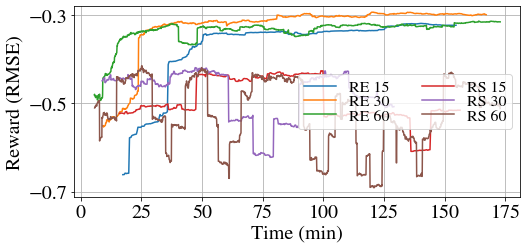

In [43]:
ESOL_re15 = load_json(r"/mnt/d/machinelearning2/ANL/ESOL/run_re15/data_2020-08-23_18.json")
ESOL_re30 = load_json(r"/mnt/d/machinelearning2/ANL/ESOL/run_0721/data_2020-07-24_13.json")
ESOL_re60 = load_json(r"/mnt/d/machinelearning2/ANL/ESOL/run_re60/data_2020-08-23_18.json")
ESOL_rs15 = load_json(r"/mnt/d/machinelearning2/ANL/ESOL/run_rs15/data_2020-08-23_03.json")
ESOL_rs30 = load_json(r"/mnt/d/machinelearning2/ANL/ESOL/run_rs30/data_2020-08-23_18.json")
ESOL_rs60 = load_json(r"/mnt/d/machinelearning2/ANL/ESOL/run_rs60/data_2020-08-23_18.json")
def moving_average(time_list, data_list, window_size=100):
    res_list = []
    times_list = []
    for i in range(len(data_list) - window_size):
        times_list.append(sum(time_list[i:i+window_size])/window_size)
        res_list.append(sum(data_list[i:i+window_size])/window_size)
    return np.array(times_list), np.array(res_list)
x, y = [], []
for data in [ESOL_re15, ESOL_re30, ESOL_re60, ESOL_rs15, ESOL_rs30, ESOL_rs60]:
    start_infos = data['start_infos'][0]
    try:
        start_time = to_sec(data['workload']['times'][0])
    except:
        start_time = to_sec(start_infos['timestamp'])
    times = [to_sec(ts)-start_time for ts in data['timestamps']]
    times, rewards = moving_average(times, data['raw_rewards'], window_size=100)
    x.append(times)
    y.append(rewards)

x = np.array(x) / 60
y = np.array(y)
PLOT_DIR = r"/mnt/d/plots/anl/"
plt.figure(figsize=(8, 3.5))
plt.plot(x[0], -(-y[0])**0.5, label='RE 15')
plt.plot(x[1], -(-y[1])**0.5, label='RE 30')
plt.plot(x[2], -(-y[2])**0.5, label='RE 60')
plt.plot(x[3], -(-y[3])**0.5, label='RS 15')
plt.plot(x[4], -(-y[4])**0.5, label='RS 30')
plt.plot(x[5], -(-y[5])**0.5, label='RS 60')
plt.xlabel('Time (min)')
plt.ylabel('Reward (RMSE)')
plt.ylim([None, -0.28])
plt.legend(ncol=2,fontsize=16, loc='center right', labelspacing=0)
plt.xticks([0, 25, 50, 75, 100, 125, 150, 175], [0, 25, 50, 75, 100, 125, 150, 175])
#plt.ylim([None, -0.57])
plt.yticks([-0.7, -0.5, -0.3])
plt.grid()
plt.savefig(PLOT_DIR+'ESOL_search_compare.png', dpi=300, bbox_inches='tight')
plt.savefig(PLOT_DIR+'ESOL_search_compare.svg', bbox_inches='tight')

In [145]:
for i in range(6):
    print(len(x[i]))

356
773
1851
368
667
1748


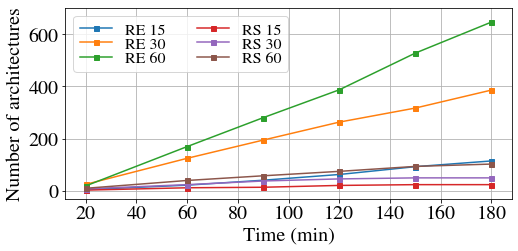

In [45]:
QM9_re15 = load_json(r"/mnt/d/machinelearning2/ANL/ESOL/run_re15/data_2020-08-23_18.json")
QM9_re30 = load_json(r"/mnt/d/machinelearning2/ANL/ESOL/run_0721/data_2020-07-24_13.json")
QM9_re60 = load_json(r"/mnt/d/machinelearning2/ANL/ESOL/run_re60/data_2020-08-23_18.json")
QM9_rs15 = load_json(r"/mnt/d/machinelearning2/ANL/ESOL/run_rs15/data_2020-08-23_03.json")
QM9_rs30 = load_json(r"/mnt/d/machinelearning2/ANL/ESOL/run_rs30/data_2020-08-23_18.json")
QM9_rs60 = load_json(r"/mnt/d/machinelearning2/ANL/ESOL/run_rs60/data_2020-08-23_18.json")
x, y = [], []
for data in [QM9_re15, QM9_re30, QM9_re60, QM9_rs15, QM9_rs30, QM9_rs60]:
    start_infos = data['start_infos'][0]
    try:
        start_time = to_sec(data['workload']['times'][0])
    except:
        start_time = to_sec(start_infos['timestamp'])
    times = [to_sec(ts)-start_time for ts in data['timestamps']]
    times = np.array(times) / 60
    rewards = np.array(data['raw_rewards'])
    xt = np.array([20, 60, 90, 120, 150, 180])
    yt = []
    for t in xt:
        idx = np.intersect1d(np.where(times <= t)[0], np.where(rewards > -0.1)[0])
        archs = len(np.unique(np.array([space.denormalize(data['arch_seq'][i]) for i in idx]), axis=0))
        yt.append(archs)
    x.append(xt)
    y.append(yt)

x = np.array(x)
y = np.array(y)
PLOT_DIR = r"/mnt/d/plots/anl/"
plt.figure(figsize=(8, 3.5))
plt.plot(x[0], y[0], label='RE 15', marker='s')
plt.plot(x[1], y[1], label='RE 30', marker='s')
plt.plot(x[2], y[2], label='RE 60', marker='s')
plt.plot(x[3], y[3], label='RS 15', marker='s')
plt.plot(x[4], y[4], label='RS 30', marker='s')
plt.plot(x[5], y[5], label='RS 60', marker='s')
plt.xlabel('Time (min)')
plt.ylabel('Number of architectures')
plt.ylim([None, 700])
plt.legend(ncol=2,fontsize=16, loc='upper left', labelspacing=0)
plt.xticks([20, 40, 60, 80, 100, 120, 140, 160, 180], [20, 40, 60, 80, 100, 120, 140, 160, 180])
#plt.yticks([0, 400, 800, 1200, 1600])
plt.grid()
plt.savefig(PLOT_DIR+'ESOL_unique.png', dpi=300, bbox_inches='tight')
plt.savefig(PLOT_DIR+'ESOL_unique.svg', bbox_inches='tight')

## Feature importance using tree interpreter

In [143]:
def feature_importance(DATA_DIR, PLOT_DIR, plot=False):
    train_data = pd.read_csv(DATA_DIR + 'nas_result.csv', header=None)
    df = train_data
    df_new = pd.DataFrame()
    for i in range(df.shape[1]):
        if (df.dtypes[i] == 'object'):
            vals = pd.get_dummies(df.iloc[:,i])
        else:
            vals = df.iloc[:,i]
        df_new = pd.concat([df_new.reset_index(drop=True), vals.reset_index(drop=True)], axis=1)
    X = df_new.iloc[:, :-1]
    y = df_new.iloc[:, -1]
    scaler = StandardScaler()
    y = scaler.fit_transform(y.values[..., np.newaxis]).squeeze()
    reg = RandomForestRegressor(n_estimators=100, random_state=0).fit(X.values, y)
    
    prediction, bias, contributions = ti.predict(reg, X.values)
    mask = np.copy(X.values)
    mask = mask.astype(float)
    mask[mask==0] = -1
    importance = np.multiply(contributions, mask)
    importance = importance.mean(axis=0)
    importance = importance / np.max(np.abs(importance))
    indices = np.argsort(importance)[-5:] 
    indices_neg = np.argsort(importance)[:5] 
    plt.figure(figsize=(8,3.5))
    plt.barh(range(5, 10), importance[indices], align='center')
    plt.barh(range(5), importance[indices_neg], align='center')
    plt.yticks(range(10), [X.columns[i] for i in indices_neg] + [X.columns[i] for i in indices] )
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig(PLOT_DIR + 'feature_importance.png', dpi=300, bbox_inches='tight')
    if not plot:
        plt.close();

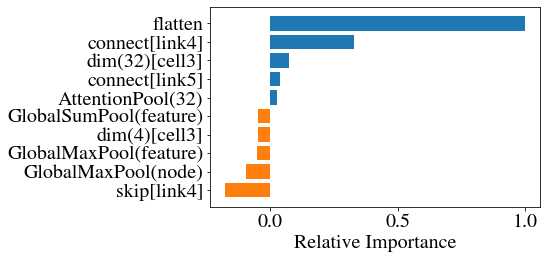

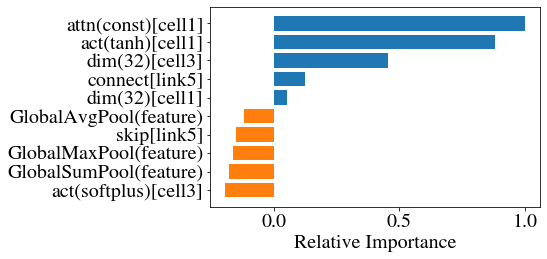

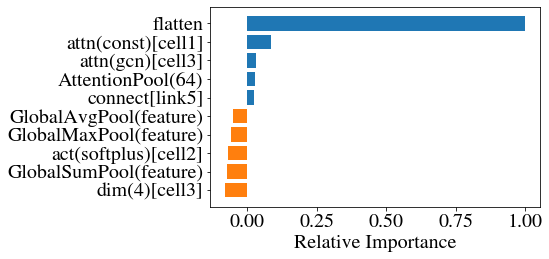

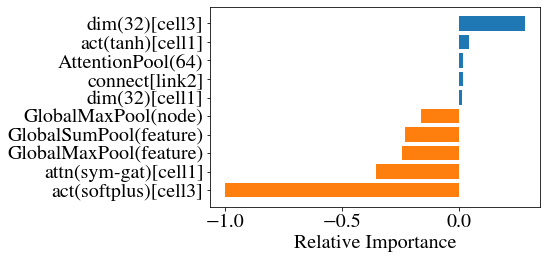

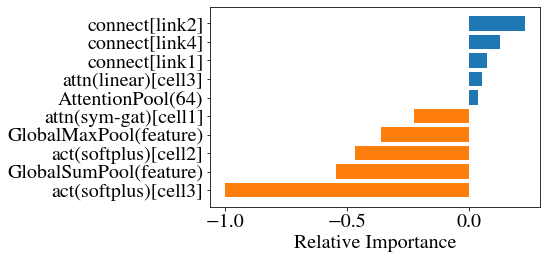

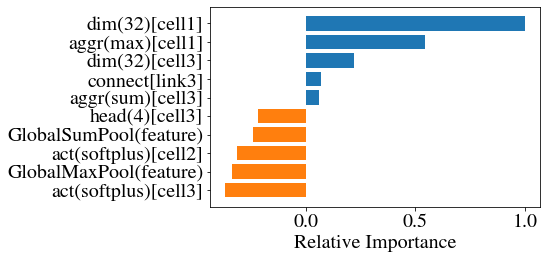

In [8]:
for i, DATA_DIR in enumerate([QM7_DATA_DIR, QM8_DATA_DIR, QM9_DATA_DIR, ESOL_DATA_DIR, FreeSolv_DATA_DIR, LIPO_DATA_DIR]):
    PLOT_DIR = [QM7_PLOT_DIR, QM8_PLOT_DIR, QM9_PLOT_DIR, ESOL_PLOT_DIR, FreeSolv_PLOT_DIR, LIPO_PLOT_DIR][i]
    feature_importance(DATA_DIR, PLOT_DIR, plot=True)

## QM7 detailed results

In [30]:
y_truev = []
y_predv = []
y_truet = []
y_predt = []
for i in range(3):
    with open(f'/mnt/d/machinelearning2/ANL/qm7/run_0721/best_archs_result_0_{i}.pickle', 'rb') as handle:
        metric = pickle.load(handle)
        _ = pickle.load(handle)
        _ = pickle.load(handle)
        y_truev.append(pickle.load(handle))
        y_predv.append(pickle.load(handle))
        y_truet.append(pickle.load(handle))
        y_predt.append(pickle.load(handle))
y_truev = np.array(y_truev)
y_predv = np.array(y_predv)
y_truet = np.array(y_truet)
y_predt = np.array(y_predt)
mse_arrayv = np.empty(3)
mse_arrayt = np.empty(3)
for i in range(3):
    temp_true = y_truev[i]
    temp_pred = y_predv[i]
    mse = mean_absolute_error(temp_true, temp_pred)
    mse_array[i] = mse
print(f"val {metric['task']}: {mse_array.mean():0.5f}+/-{mse_array.std():0.5f}")
for i in range(3):
    temp_true = y_truet[i]
    temp_pred = y_predt[i]
    mse = mean_absolute_error(temp_true, temp_pred)
    mse_array[i] = mse
print(f"test {metric['task']}: {mse_array.mean():0.5f}+/-{mse_array.std():0.5f}")

val ['u0_atom']: 38.33255+/-1.12306
test ['u0_atom']: 48.01901+/-0.67840


## QM8 detailed results

In [4]:
y_truev = []
y_predv = []
y_truet = []
y_predt = []
for i in range(3):
    with open(f'/mnt/d/machinelearning2/ANL/qm8/run_0721/best_archs_result_0_{i}.pickle', 'rb') as handle:
        metric = pickle.load(handle)
        _ = pickle.load(handle)
        _ = pickle.load(handle)
        y_truev.append(pickle.load(handle))
        y_predv.append(pickle.load(handle))
        y_truet.append(pickle.load(handle))
        y_predt.append(pickle.load(handle))
y_truev = np.array(y_truev)
y_predv = np.array(y_predv)
y_truet = np.array(y_truet)
y_predt = np.array(y_predt)

mse_arrayv = np.empty((3, 16))
mse_arrayt = np.empty((3, 16))
for i in range(3):
    for j in range(16):
        temp_true = y_truev[i, ..., j]
        temp_pred = y_predv[i, ..., j]
        mse = mean_absolute_error(temp_true, temp_pred)
        mse_arrayv[i, j] = mse
for i in range(16):
    print(f"val {metric['task'][i]}: {mse_arrayv[..., i].mean():0.5f}+/-{mse_arrayv[..., i].std():0.5f}")
for i in range(3):
    for j in range(16):
        temp_true = y_truet[i, ..., j]
        temp_pred = y_predt[i, ..., j]
        mse = mean_absolute_error(temp_true, temp_pred)
        mse_arrayt[i, j] = mse
for i in range(16):
    print(f"test {metric['task'][i]}: {mse_arrayt[..., i].mean():0.5f}+/-{mse_arrayt[..., i].std():0.5f}")

val E1-CC2: 0.00680+/-0.00009
val E2-CC2: 0.00792+/-0.00016
val f1-CC2: 0.01383+/-0.00016
val f2-CC2: 0.02957+/-0.00028
val E1-PBE0: 0.00644+/-0.00004
val E2-PBE0: 0.00719+/-0.00010
val f1-PBE0: 0.00964+/-0.00009
val f2-PBE0: 0.02132+/-0.00055
val E1-PBE0: 0.00644+/-0.00004
val E2-PBE0: 0.00719+/-0.00010
val f1-PBE0: 0.00965+/-0.00009
val f2-PBE0: 0.02133+/-0.00053
val E1-CAM: 0.00628+/-0.00008
val E2-CAM: 0.00680+/-0.00014
val f1-CAM: 0.01121+/-0.00004
val f2-CAM: 0.02365+/-0.00034
test E1-CC2: 0.00675+/-0.00003
test E2-CC2: 0.00792+/-0.00003
test f1-CC2: 0.01293+/-0.00019
test f2-CC2: 0.02910+/-0.00053
test E1-PBE0: 0.00637+/-0.00007
test E2-PBE0: 0.00724+/-0.00012
test f1-PBE0: 0.01039+/-0.00024
test f2-PBE0: 0.02163+/-0.00053
test E1-PBE0: 0.00637+/-0.00007
test E2-PBE0: 0.00724+/-0.00012
test f1-PBE0: 0.01039+/-0.00024
test f2-PBE0: 0.02164+/-0.00051
test E1-CAM: 0.00629+/-0.00008
test E2-CAM: 0.00693+/-0.00016
test f1-CAM: 0.01168+/-0.00021
test f2-CAM: 0.02356+/-0.00008


## QM9 detailed results

In [34]:
y_truev = []
y_predv = []
y_truet = []
y_predt = []
for i in range(3):
    with open(f'/mnt/d/machinelearning2/ANL/qm9/run_0728/best_archs_result_0_{i}.pickle', 'rb') as handle:
        metric = pickle.load(handle)
        _ = pickle.load(handle)
        _ = pickle.load(handle)
        y_truev.append(pickle.load(handle))
        y_predv.append(pickle.load(handle))
        y_truet.append(pickle.load(handle))
        y_predt.append(pickle.load(handle))
y_truev = np.array(y_truev)
y_predv = np.array(y_predv)
y_truet = np.array(y_truet)
y_predt = np.array(y_predt)

mse_arrayv = np.empty((3, 12))
mse_arrayt = np.empty((3, 12))
for i in range(3):
    for j in range(12):
        temp_true = y_truev[i, ..., j]
        temp_pred = y_predv[i, ..., j]
        mse = mean_absolute_error(temp_true, temp_pred)
        mse_arrayv[i, j] = mse
for i in range(12):
    print(f"val {metric['task'][i]}: {mse_arrayv[..., i].mean():0.5f}+/-{mse_arrayv[..., i].std():0.5f}")
for i in range(3):
    for j in range(12):
        temp_true = y_truet[i, ..., j]
        temp_pred = y_predt[i, ..., j]
        mse = mean_absolute_error(temp_true, temp_pred)
        mse_arrayt[i, j] = mse
for i in range(12):
    print(f"test {metric['task'][i]}: {mse_arrayt[..., i].mean():0.5f}+/-{mse_arrayt[..., i].std():0.5f}")

val mu: 0.56801+/-0.00562
val alpha: 0.68358+/-0.00704
val homo: 0.00559+/-0.00007
val lumo: 0.00607+/-0.00008
val gap: 0.00801+/-0.00002
val r2: 40.94710+/-0.53553
val zpve: 0.00130+/-0.00015
val cv: 0.34743+/-0.00440
val u0: 0.64783+/-0.06369
val u298: 0.61766+/-0.05329
val h298: 0.67669+/-0.12059
val g298: 0.66078+/-0.05928
test mu: 0.56446+/-0.00295
test alpha: 0.69305+/-0.00653
test homo: 0.00560+/-0.00004
test lumo: 0.00602+/-0.00002
test gap: 0.00799+/-0.00004
test r2: 41.31871+/-0.57822
test zpve: 0.00130+/-0.00014
test cv: 0.34768+/-0.00603
test u0: 0.64658+/-0.05974
test u298: 0.61882+/-0.04942
test h298: 0.67783+/-0.11371
test g298: 0.66138+/-0.05339


## ESOL detailed results

In [40]:
y_truev = []
y_predv = []
y_truet = []
y_predt = []
for i in range(3):
    with open(f'/mnt/d/machinelearning2/ANL/ESOL/run_0721/best_archs_result_0_{i}.pickle', 'rb') as handle:
        metric = pickle.load(handle)
        _ = pickle.load(handle)
        _ = pickle.load(handle)
        y_truev.append(pickle.load(handle))
        y_predv.append(pickle.load(handle))
        y_truet.append(pickle.load(handle))
        y_predt.append(pickle.load(handle))
y_truev = np.array(y_truev)
y_predv = np.array(y_predv)
y_truet = np.array(y_truet)
y_predt = np.array(y_predt)
mse_arrayv = np.empty(3)
mse_arrayt = np.empty(3)
for i in range(3):
    temp_true = y_truev[i]
    temp_pred = y_predv[i]
    mse = mean_squared_error(temp_true, temp_pred)**0.5
    mse_array[i] = mse
print(f"val {metric['task']}: {mse_array.mean():0.5f}+/-{mse_array.std():0.5f}")
for i in range(3):
    temp_true = y_truet[i]
    temp_pred = y_predt[i]
    mse = mean_squared_error(temp_true, temp_pred)**0.5
    mse_array[i] = mse
print(f"test {metric['task']}: {mse_array.mean():0.5f}+/-{mse_array.std():0.5f}")

val ['measured log solubility in mols per litre']: 0.62805+/-0.00512
test ['measured log solubility in mols per litre']: 0.53544+/-0.00602


## FreeSolv detailed results

In [43]:
y_truev = []
y_predv = []
y_truet = []
y_predt = []
for i in range(3):
    with open(f'/mnt/d/machinelearning2/ANL/FreeSolv/run_0721/best_archs_result_0_{i}.pickle', 'rb') as handle:
        metric = pickle.load(handle)
        _ = pickle.load(handle)
        _ = pickle.load(handle)
        y_truev.append(pickle.load(handle))
        y_predv.append(pickle.load(handle))
        y_truet.append(pickle.load(handle))
        y_predt.append(pickle.load(handle))
y_truev = np.array(y_truev)
y_predv = np.array(y_predv)
y_truet = np.array(y_truet)
y_predt = np.array(y_predt)
mse_arrayv = np.empty(3)
mse_arrayt = np.empty(3)
for i in range(3):
    temp_true = y_truev[i]
    temp_pred = y_predv[i]
    mse = mean_squared_error(temp_true, temp_pred)**0.5
    mse_array[i] = mse
print(f"val {metric['task']}: {mse_array.mean():0.5f}+/-{mse_array.std():0.5f}")
for i in range(3):
    temp_true = y_truet[i]
    temp_pred = y_predt[i]
    mse = mean_squared_error(temp_true, temp_pred)**0.5
    mse_array[i] = mse
print(f"test {metric['task']}: {mse_array.mean():0.5f}+/-{mse_array.std():0.5f}")

val ['expt']: 0.83585+/-0.09410
test ['expt']: 1.20733+/-0.03465


## Lipo detailed results

In [44]:
y_truev = []
y_predv = []
y_truet = []
y_predt = []
for i in range(3):
    with open(f'/mnt/d/machinelearning2/ANL/Lipo/run_0721/best_archs_result_0_{i}.pickle', 'rb') as handle:
        metric = pickle.load(handle)
        _ = pickle.load(handle)
        _ = pickle.load(handle)
        y_truev.append(pickle.load(handle))
        y_predv.append(pickle.load(handle))
        y_truet.append(pickle.load(handle))
        y_predt.append(pickle.load(handle))
y_truev = np.array(y_truev)
y_predv = np.array(y_predv)
y_truet = np.array(y_truet)
y_predt = np.array(y_predt)
mse_arrayv = np.empty(3)
mse_arrayt = np.empty(3)
for i in range(3):
    temp_true = y_truev[i]
    temp_pred = y_predv[i]
    mse = mean_squared_error(temp_true, temp_pred)**0.5
    mse_array[i] = mse
print(f"val {metric['task']}: {mse_array.mean():0.5f}+/-{mse_array.std():0.5f}")
for i in range(3):
    temp_true = y_truet[i]
    temp_pred = y_predt[i]
    mse = mean_squared_error(temp_true, temp_pred)**0.5
    mse_array[i] = mse
print(f"test {metric['task']}: {mse_array.mean():0.5f}+/-{mse_array.std():0.5f}")

val ['exp']: 0.60448+/-0.01515
test ['exp']: 0.59833+/-0.04303


## Single value regression parity plots

In [11]:
def three_random_parity_plot(DATA_DIR, PLOT_DIR, multi_class=False, limits=None, plot=False, ticks=None):
    _, _, _, _, y_true_raw, y_pred_raw = three_random_split(DATA_DIR, multi_class=multi_class)
    if not multi_class:
        y_true = y_true_raw.ravel()
        y_pred = y_pred_raw.ravel()
        scaler = StandardScaler()
        y_true = scaler.fit_transform(y_true[..., np.newaxis]).squeeze()
        y_pred = scaler.fit_transform(y_pred[..., np.newaxis]).squeeze()
        fig, ax = plt.subplots(figsize=(4,2))
        min_value = np.min([y_true.min(), y_pred.min()])
        max_value = np.max([y_true.max(), y_pred.max()])
        dist = max_value - min_value
        min_value -= 0.03*dist
        max_value += 0.03*dist
        if limits is not None:
            min_value, max_value = limits
        ax.plot(np.linspace(min_value, max_value, 100), np.linspace(min_value, max_value, 100), 'k--', alpha=0.5)
        ax.scatter(y_true.ravel(), y_pred.ravel(), s=5, alpha=0.9)
        plt.xlim(min_value, max_value)
        plt.ylim(min_value, max_value)
        plt.xlabel("True")
        plt.ylabel("Predicted")
        print(min_value, max_value)
        from matplotlib import ticker
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-1,1))
        if ticks is not None:
            plt.xticks(ticks, ticks)
            plt.yticks(ticks, ticks)
        else:
            plt.locator_params(axis='x', nbins=5)
            plt.locator_params(axis='y', nbins=5)
        ax.xaxis.set_major_formatter(formatter)
        ax.yaxis.set_major_formatter(formatter)
        # plt.tight_layout()
        plt.savefig(PLOT_DIR + "parity_plot.png", bbox_inches='tight')
        #plt.savefig(PLOT_DIR + "parity_plot.svg", bbox_inches='tight')
        if not plot:
            plt.close();

-3.146825802837292 5.399544920407421
-2.1 4
-2.1 7.7
-3.156182044692738 2.314295721671504
-3.1804387445175593 2.027306336565121
-3.381278715882268 2.195185291446684


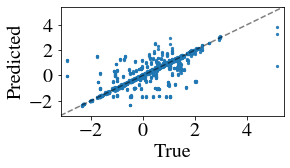

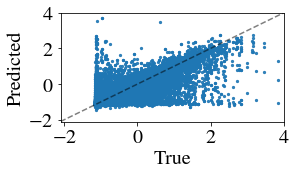

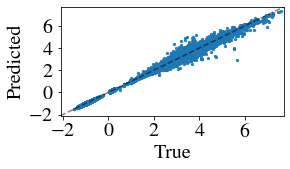

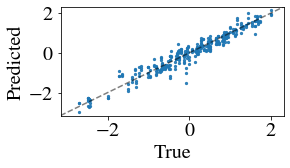

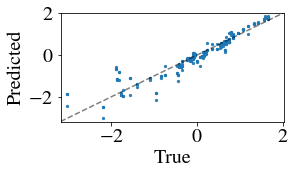

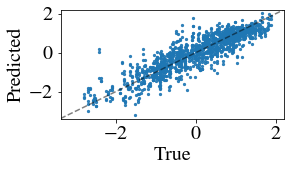

In [12]:
three_random_parity_plot(QM7_DATA_DIR, QM7_PLOT_DIR, plot=True)

three_random_parity_plot(QM8_DATA_DIR, QM8_PLOT_DIR, plot=True, limits=[-2.1, 4])

three_random_parity_plot(QM9_DATA_DIR, QM9_PLOT_DIR, plot=True, limits=[-2.1, 7.7], ticks=[-2, 0, 2, 4, 6])

three_random_parity_plot(ESOL_DATA_DIR, ESOL_PLOT_DIR, plot=True)

three_random_parity_plot(FreeSolv_DATA_DIR, FreeSolv_PLOT_DIR, plot=True)

three_random_parity_plot(LIPO_DATA_DIR, LIPO_PLOT_DIR, plot=True)